In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['Black Spot', 'Downly Mildew', 'Fresh Leaf']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [5]:
# Setup directory paths to train and test images
train_dir = 'F:/ADITYA SIR/ROSE/train'
test_dir = 'F:/ADITYA SIR/ROSE/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [9]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2997 | train_acc: 0.9229 | test_loss: 0.1657 | test_acc: 0.9699
Epoch: 2 | train_loss: 0.1036 | train_acc: 0.9799 | test_loss: 0.1062 | test_acc: 0.9810
Epoch: 3 | train_loss: 0.0699 | train_acc: 0.9880 | test_loss: 0.0714 | test_acc: 0.9888
Epoch: 4 | train_loss: 0.0537 | train_acc: 0.9914 | test_loss: 0.0653 | test_acc: 0.9866
Epoch: 5 | train_loss: 0.0433 | train_acc: 0.9940 | test_loss: 0.0502 | test_acc: 0.9911
Epoch: 6 | train_loss: 0.0362 | train_acc: 0.9946 | test_loss: 0.0454 | test_acc: 0.9911
Epoch: 7 | train_loss: 0.0305 | train_acc: 0.9960 | test_loss: 0.0450 | test_acc: 0.9911
Epoch: 8 | train_loss: 0.0262 | train_acc: 0.9971 | test_loss: 0.0380 | test_acc: 0.9922
Epoch: 9 | train_loss: 0.0236 | train_acc: 0.9974 | test_loss: 0.0339 | test_acc: 0.9933
Epoch: 10 | train_loss: 0.0207 | train_acc: 0.9980 | test_loss: 0.0335 | test_acc: 0.9922


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


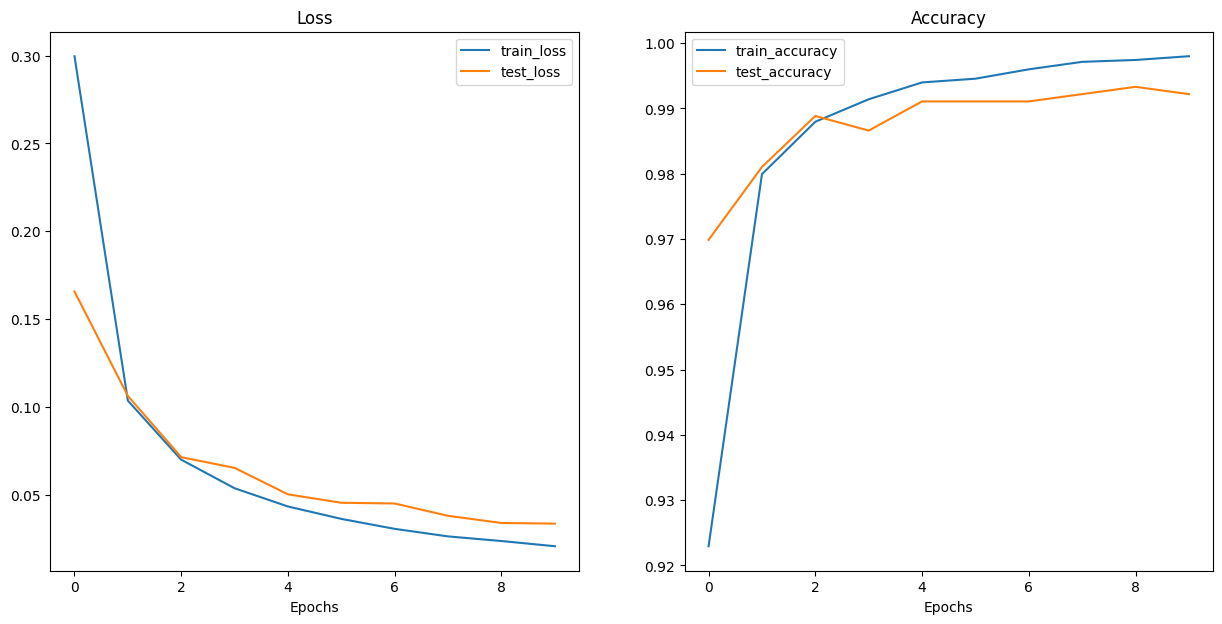

In [24]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

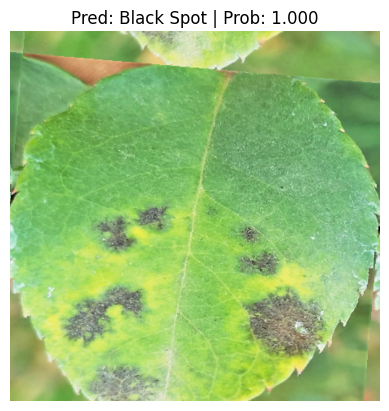

In [25]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "1.png"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

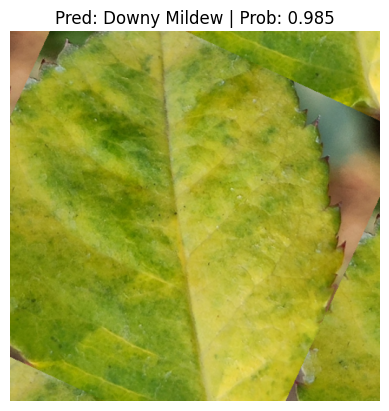

In [26]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "2.png"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

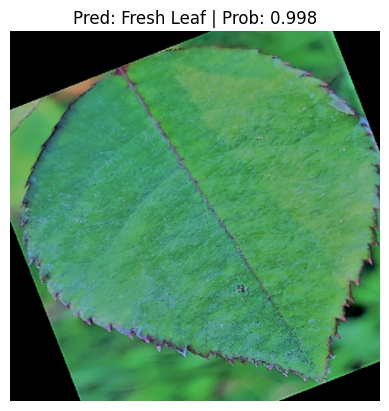

In [27]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "3.png"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

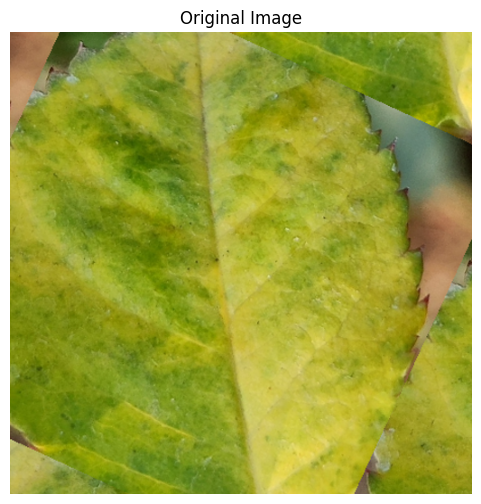

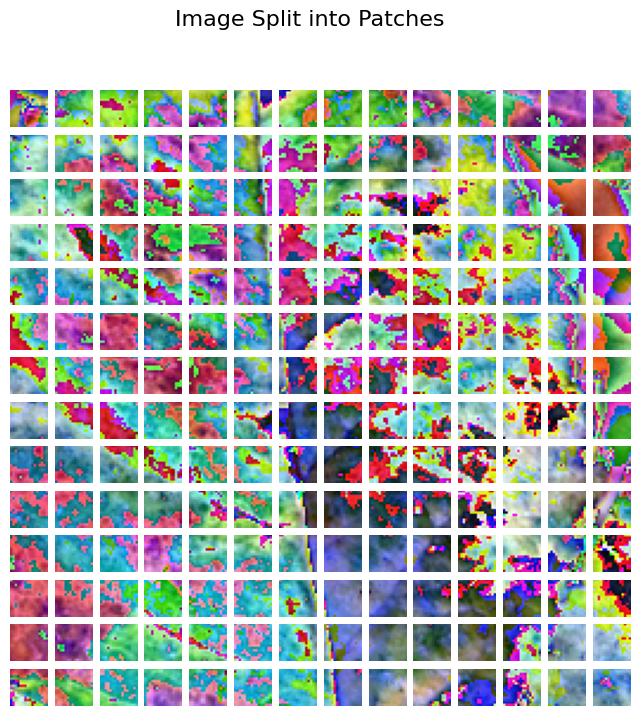

Predicted class: Downy Mildew


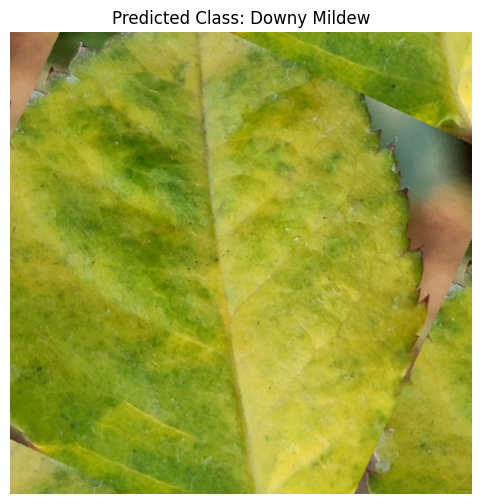

In [28]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# Load a custom image
custom_image_path = "2.png"
image = Image.open(custom_image_path)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Step 1: Transform the image to match ViT input requirements
pretrained_vit_transforms = pretrained_vit_weights.transforms()
transformed_image = pretrained_vit_transforms(image).unsqueeze(0).to(device)  # Add batch dimension

# Step 2: Visualize image patches (ViT splits image into 16x16 patches)
def show_image_patches(image_tensor, patch_size=16):
    # Convert the tensor back to a NumPy array for visualization
    image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Remove batch dim and re-order channels
    height, width, _ = image_np.shape

    # Rescale pixel values back to 0-255 range
    image_np = (image_np * 255).astype(np.uint8)

    # Calculate number of patches
    num_patches_x = width // patch_size
    num_patches_y = height // patch_size

    # Create figure
    fig, ax = plt.subplots(num_patches_y, num_patches_x, figsize=(8, 8))

    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = image_np[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size, :]
            ax[i, j].imshow(patch)
            ax[i, j].axis('off')

    plt.suptitle("Image Split into Patches", fontsize=16)
    plt.show()

# Show the image divided into 16x16 patches
show_image_patches(image_tensor=transformed_image, patch_size=16)

# Step 3: Feed the transformed image through the Vision Transformer
pretrained_vit.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Get the prediction for the image
    output = pretrained_vit(transformed_image)

# Step 4: Visualize the classification result
predicted_class_idx = torch.argmax(output, dim=1).item()
predicted_class = class_names[predicted_class_idx]

print(f"Predicted class: {predicted_class}")

# Step 5: Plot the original image with the predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()


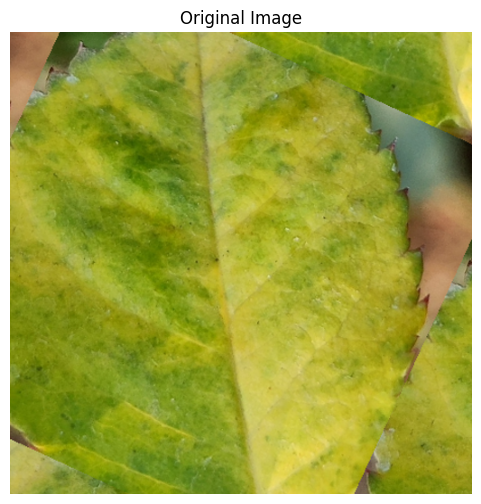

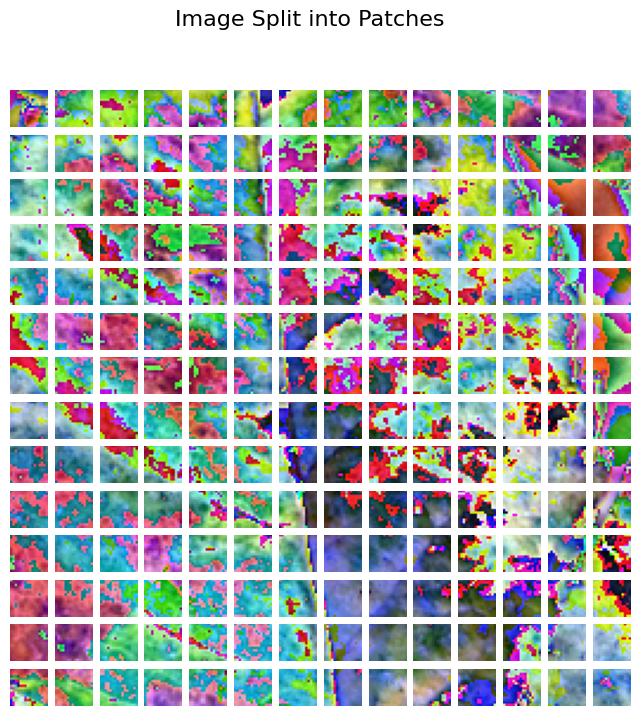

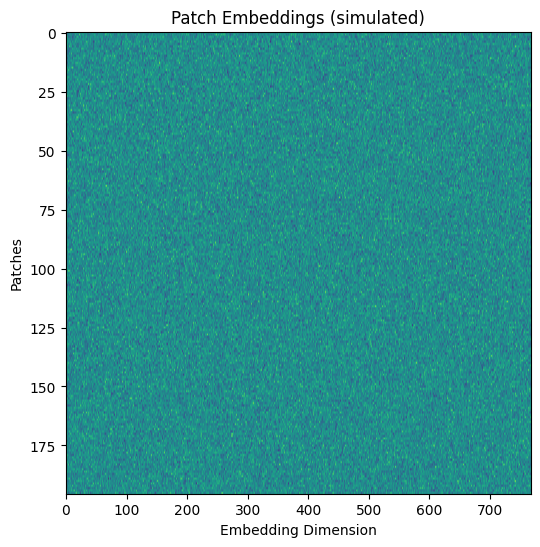

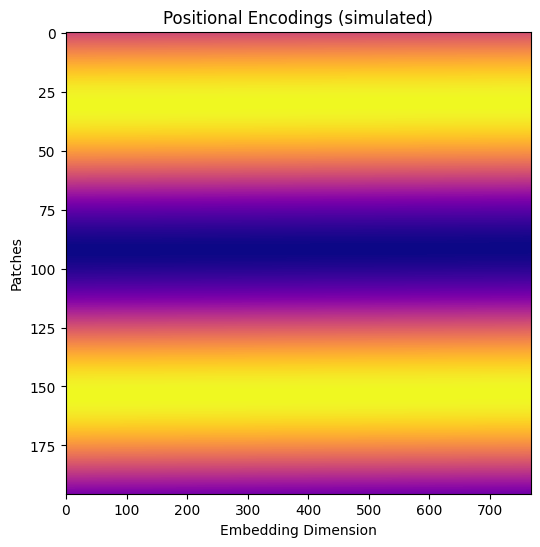

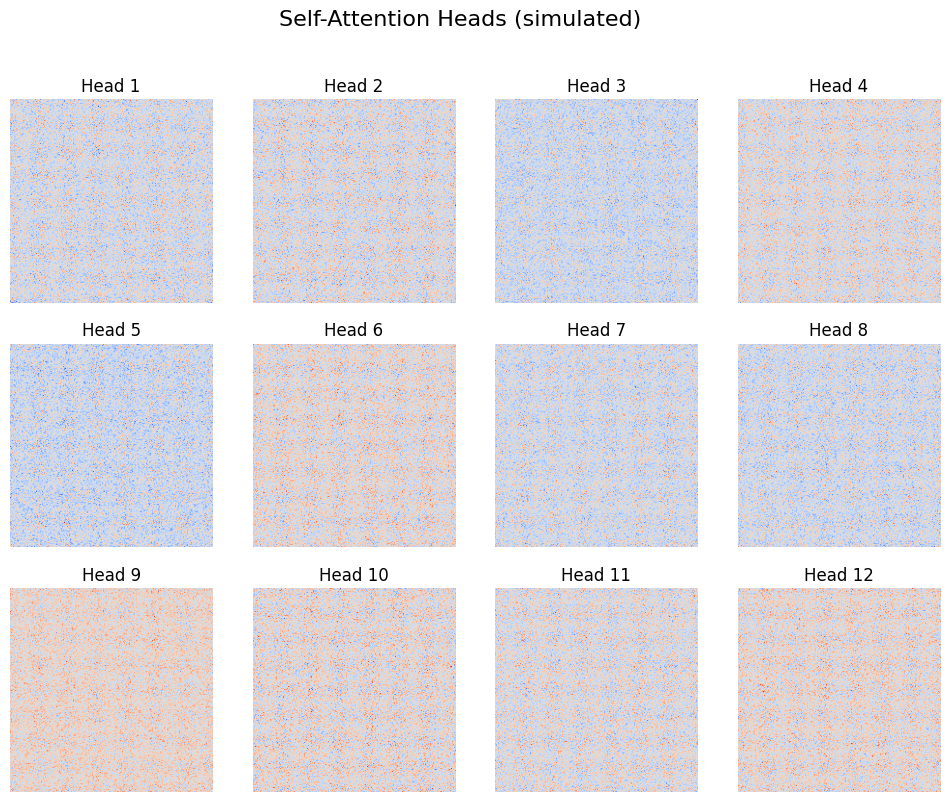

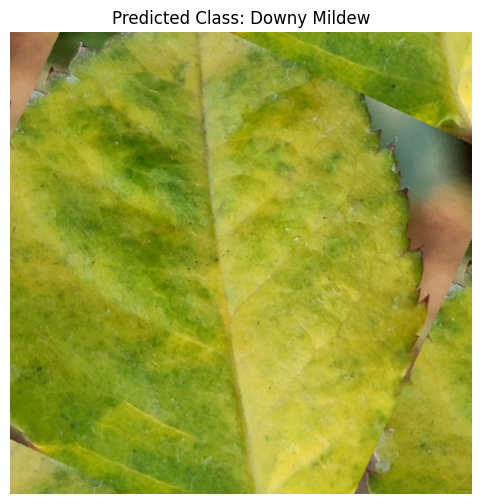

In [29]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# Load a custom image
custom_image_path = "2.png"
image = Image.open(custom_image_path)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Step 1: Transform the image to match ViT input requirements
pretrained_vit_transforms = pretrained_vit_weights.transforms()
transformed_image = pretrained_vit_transforms(image).unsqueeze(0).to(device)  # Add batch dimension

# Step 2: Show the image patches
def show_image_patches(image_tensor, patch_size=16):
    # Convert the tensor back to a NumPy array for visualization
    image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Remove batch dim and re-order channels
    height, width, _ = image_np.shape

    # Rescale pixel values back to 0-255 range
    image_np = (image_np * 255).astype(np.uint8)

    # Calculate number of patches
    num_patches_x = width // patch_size
    num_patches_y = height // patch_size

    # Create figure
    fig, ax = plt.subplots(num_patches_y, num_patches_x, figsize=(8, 8))

    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = image_np[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size, :]
            ax[i, j].imshow(patch)
            ax[i, j].axis('off')

    plt.suptitle("Image Split into Patches", fontsize=16)
    plt.show()

# Show the image divided into 16x16 patches
show_image_patches(image_tensor=transformed_image, patch_size=16)

# Step 3: Show patch embedding process
# Visualize patches as linear embeddings
def show_patch_embeddings(image_tensor, patch_size=16, embed_dim=768):
    num_patches = (image_tensor.shape[-1] // patch_size) ** 2
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Create random embeddings to simulate the step
    patch_embeddings = np.random.randn(num_patches, embed_dim)

    # Visualizing the embeddings as a heatmap
    ax.imshow(patch_embeddings, cmap='viridis', aspect='auto')
    ax.set_title("Patch Embeddings (simulated)")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Patches")
    plt.show()

# Show simulated patch embeddings
show_patch_embeddings(image_tensor=transformed_image, patch_size=16)

# Step 4: Add positional encodings to the embeddings (simulate)
def show_positional_encodings(patch_size=16, embed_dim=768, num_patches=196):
    # Simulating positional encodings as sinusoidal functions
    positional_encodings = np.sin(np.linspace(0, 10, num_patches * embed_dim)).reshape(num_patches, embed_dim)

    # Plotting the positional encodings as heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(positional_encodings, cmap='plasma', aspect='auto')
    plt.title("Positional Encodings (simulated)")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Patches")
    plt.show()

# Show positional encodings (simulated)
show_positional_encodings()

# Step 5: Process image through the transformer layers
# Visualize a generic self-attention process (simulated)
def show_attention_heads(num_heads=12, num_patches=196):
    # Simulating attention as random weights between patches
    attention_weights = np.random.randn(num_heads, num_patches, num_patches)

    fig, ax = plt.subplots(3, 4, figsize=(12, 9))  # 12 heads, arranged in 3x4 grid
    fig.suptitle("Self-Attention Heads (simulated)", fontsize=16)

    for i in range(3):
        for j in range(4):
            ax[i, j].imshow(attention_weights[i * 4 + j], cmap='coolwarm', aspect='auto')
            ax[i, j].axis('off')
            ax[i, j].set_title(f"Head {i * 4 + j + 1}")

    plt.show()

# Show simulated self-attention heads
show_attention_heads()

# Step 6: Predict the class for the image
pretrained_vit.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Get the prediction for the image
    output = pretrained_vit(transformed_image)

# Step 7: Visualize the final predicted class
predicted_class_idx = torch.argmax(output, dim=1).item()
predicted_class = class_names[predicted_class_idx]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import numpy as np
import torch


In [33]:
def get_predictions_and_labels(dataloader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [35]:
import numpy as np
import torch

def get_predictions_and_labels(dataloader, model, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    y_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_probs.extend(probabilities[:, 1].cpu().numpy())  # Probabilities for the positive class
    
    return np.array(y_true), np.array(y_pred), np.array(y_probs)


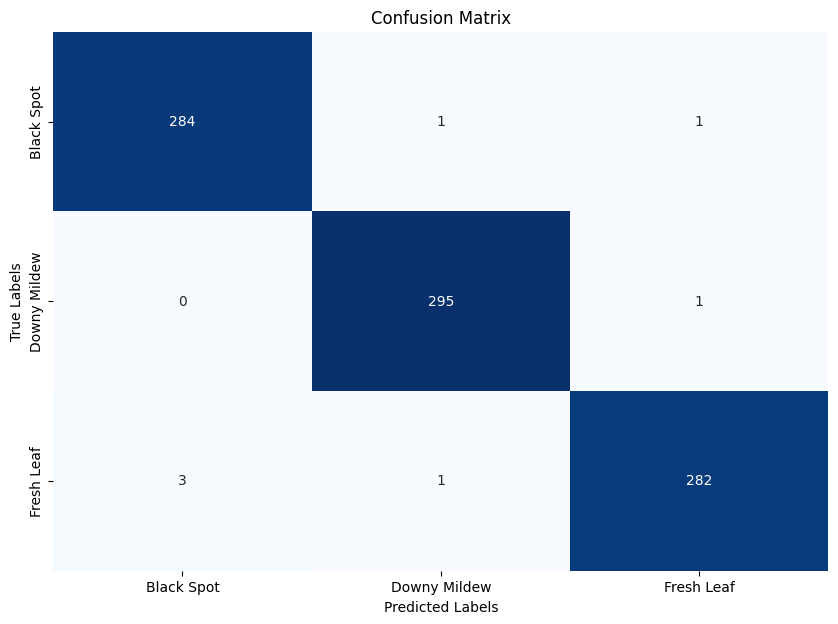

In [37]:
# Get predictions and true labels
y_true, y_pred, y_probs = get_predictions_and_labels(test_dataloader_pretrained, pretrained_vit, device)

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_names)



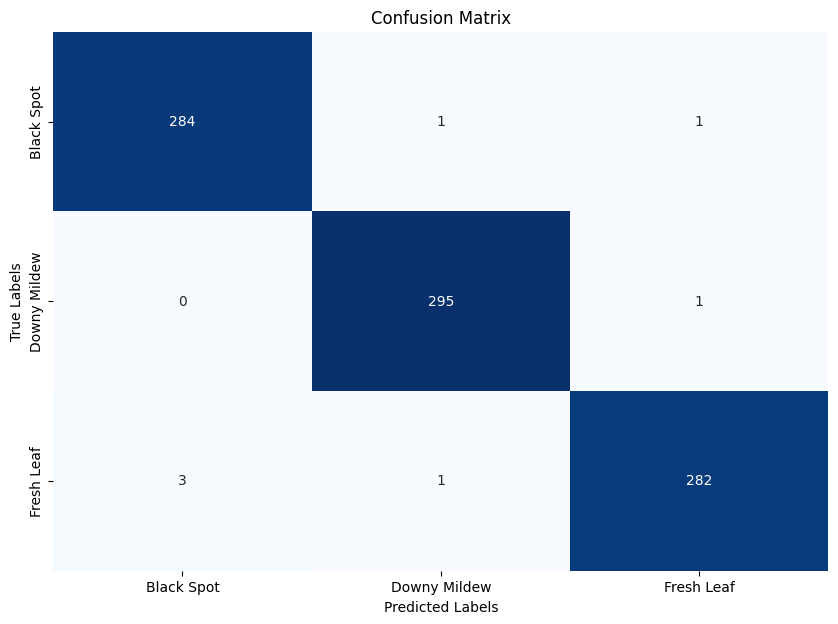

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_names)


In [53]:
def get_predictions_and_labels(dataloader, model, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    y_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)  # Get probabilities for all classes
            predictions = torch.argmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_probs.extend(probabilities.cpu().numpy())  # Collect probabilities for all classes
    
    return np.array(y_true), np.array(y_pred), np.array(y_probs)


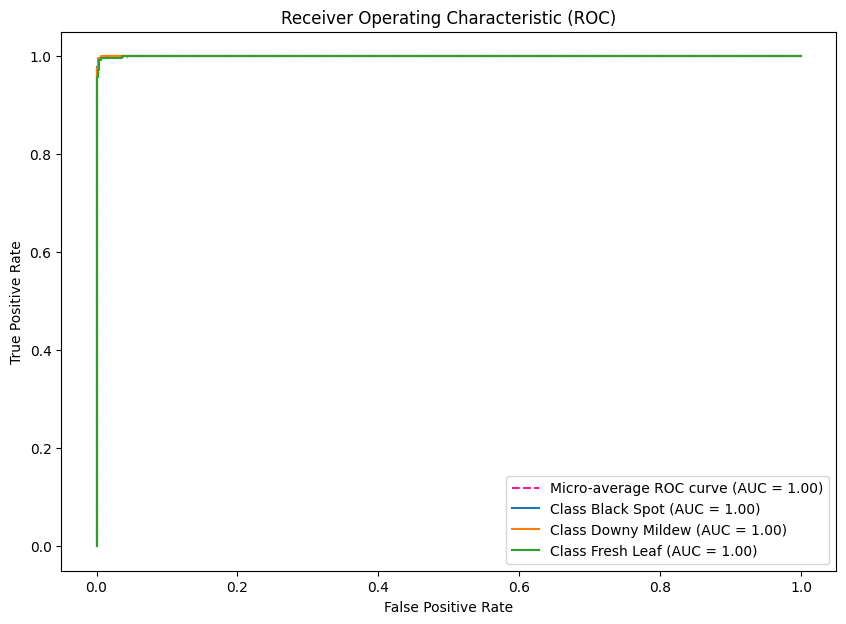

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve_multiclass(y_true, y_probs, class_names):
    # Ensure y_probs is 2D
    if y_probs.ndim == 1:
        raise ValueError("y_probs should be a 2D array with shape (n_samples, n_classes)")

    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

    # Initialize dictionaries to store ROC curve data
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and ROC AUC for each class
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute ROC curve and ROC AUC for micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 7))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle='--')
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='best')
    plt.show()

# Example usage:
y_true, y_pred, y_probs = get_predictions_and_labels(test_dataloader_pretrained, pretrained_vit, device)
plot_roc_curve_multiclass(y_true, y_probs, class_names)
